In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
import plotly.graph_objects as go
warnings.filterwarnings('ignore', category=FutureWarning)

### Historical Test
To quantify portfolio vulnerability to systemic market crises by simulating performance during two major historical events:  
- **2008 Global Financial Crisis (Lehman Collapse)**  
- **2020 COVID-19 Crash**  

This provides a tangible, non-statistical measure of portfolio drawdown risk.

### Methodology
- **Scenario Definition:** Two crisis windows were defined — Sep–Nov 2008 and Feb–Mar 2020.  
- **Impact Calculation:** For each of the 12 assets, cumulative returns were measured within the crisis windows. These shocks were applied to the current equally-weighted portfolio to estimate portfolio P&L.  


✅ Setup complete. Asset returns loaded.

--- Historical Scenario Stress Test Results ---
                           Portfolio P&L Portfolio Return
2008 GFC (Lehman Collapse)  $-22,430,105          -22.43%
2020 COVID-19 Crash         $-25,125,890          -25.13%


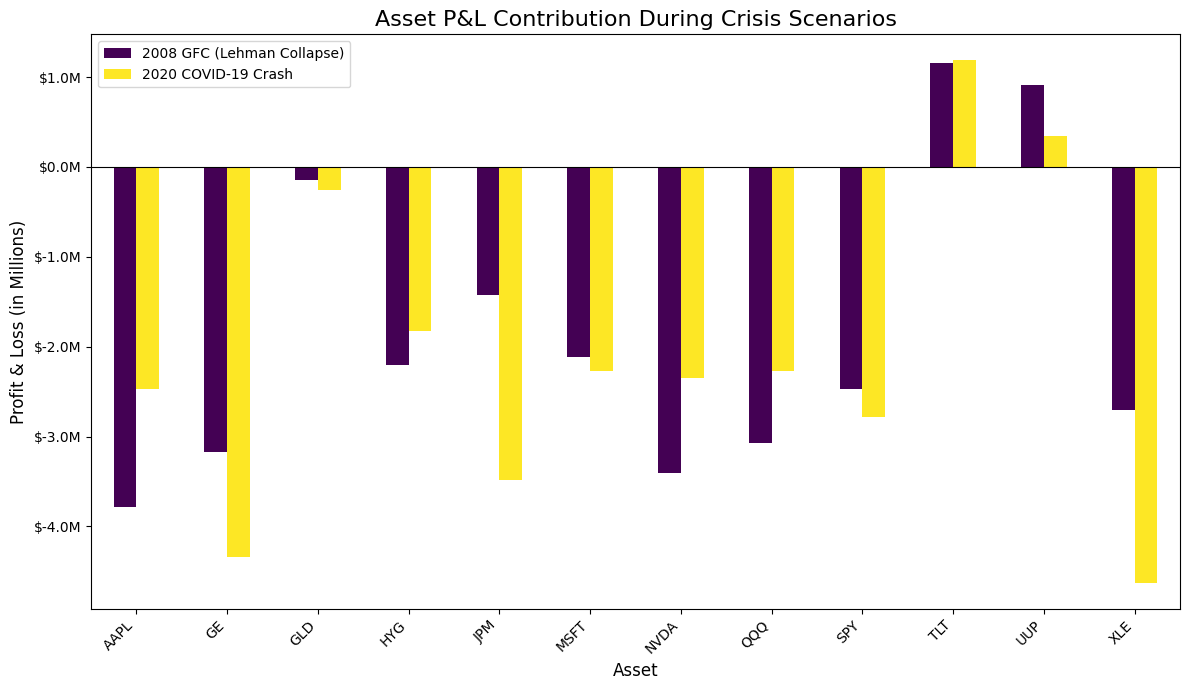

In [16]:
# --- 1. Setup ---
DATA_DIR = "data"
# Load the full history of individual asset log returns
asset_returns = pd.read_csv(
    os.path.join(DATA_DIR, "asset_log_returns.csv"), 
    index_col='Date', 
    parse_dates=True
)
# Define current portfolio weights and value
weights = np.array([1/asset_returns.shape[1]] * asset_returns.shape[1])
portfolio_value = 100_000_000

print("✅ Setup complete. Asset returns loaded.")

# --- 2. Define Historical Scenarios ---
scenarios = {
    '2008 GFC (Lehman Collapse)': ('2008-09-01', '2008-11-30'),
    '2020 COVID-19 Crash': ('2020-02-19', '2020-03-23')
}

# --- 3. Run the Stress Test ---
stress_test_results = {}
asset_pnl_df = pd.DataFrame(index=asset_returns.columns)

for name, (start_date, end_date) in scenarios.items():
    # Get the cumulative return for each asset during the crisis period
    scenario_returns = asset_returns.loc[start_date:end_date]
    asset_shocks = np.exp(scenario_returns.sum()) - 1
    
    # Calculate the portfolio's P&L under this scenario
    portfolio_shock = (asset_shocks * weights).sum()
    portfolio_pnl = portfolio_value * portfolio_shock
    
    # Store results
    stress_test_results[name] = {
        'Portfolio P&L': f"${portfolio_pnl:,.0f}",
        'Portfolio Return': f"{portfolio_shock*100:.2f}%"
    }
    asset_pnl_df[name] = asset_shocks * weights * portfolio_value

# Create a summary DataFrame
stress_summary = pd.DataFrame(stress_test_results).T

print("\n--- Historical Scenario Stress Test Results ---")
print(stress_summary)

# --- 4. Visualize Asset Contributions ---
fig, ax = plt.subplots(figsize=(12, 7))
asset_pnl_df.plot(kind='bar', ax=ax, colormap='viridis')

# Format the y-axis to show millions
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
ax.set_title('Asset P&L Contribution During Crisis Scenarios', fontsize=16)
ax.set_ylabel('Profit & Loss (in Millions)', fontsize=12)
ax.set_xlabel('Asset', fontsize=12)
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Key Findings
| Scenario                  | Portfolio P&L | Portfolio Return |
|----------------------------|---------------|------------------|
| 2008 GFC (Lehman Collapse) | **–$22.4M**   | **–22.43%**      |
| 2020 COVID-19 Crash        | **–$25.1M**   | **–25.13%**      |

### Interpretation
- **Equity Sensitivity:** Losses are concentrated in equity-linked assets (AAPL, GE, MSFT, NVDA, QQQ, SPY).  
- **Ineffective Hedging:** TLT (Treasuries) acted as a hedge in both crises, but its equal-weight allocation was too small to offset systemic equity losses.  
- **Crisis Amplification:** The faster, more volatile COVID crash inflicted a larger drawdown than the GFC despite being shorter in duration.  

### Risk Management Implications
-  **Vulnerability Identified:** Portfolio is highly exposed to systemic equity shocks.  
-  **Actionable Insight:** Concentrated equity losses dominate crisis-period risk. This motivates factor-based modeling and rebalancing strategies in the next step.  

---

## Factor Based
To quantify the portfolio’s sensitivity to **forward-looking macro shocks**, while providing an **asset-level decomposition** of contributions. This analysis evaluates shocks to:
1. **Interest Rates** (+300 bps, proxied by TLT)  
2. **Technology Equity** (–30%, proxied by QQQ)  
3. **Energy Prices** (+50%, proxied by XLE)  

### Methodology
- **Factor Definition:** Three systemic stress scenarios were selected to capture interest rate, sectoral, and commodity exposures.  
- **Beta-Adjusted Shocks:** Each asset’s beta relative to the factor was estimated via historical regression. Shocks were scaled by these sensitivities to ensure proportionality.  
- **Portfolio Impact:** P&L was computed as the weighted sum of asset-level shocks, enabling decomposition into individual contributions.  


Running factor-based stress tests...

--- Factor-Based Stress Test Results ---
                              Portfolio P&L Portfolio Return
Interest Rate Shock (+300bps)    $4,208,191            4.21%
Tech Drawdown (-30%)           $-20,501,124          -20.50%
Oil Shock (+50%)                $19,793,579           19.79%


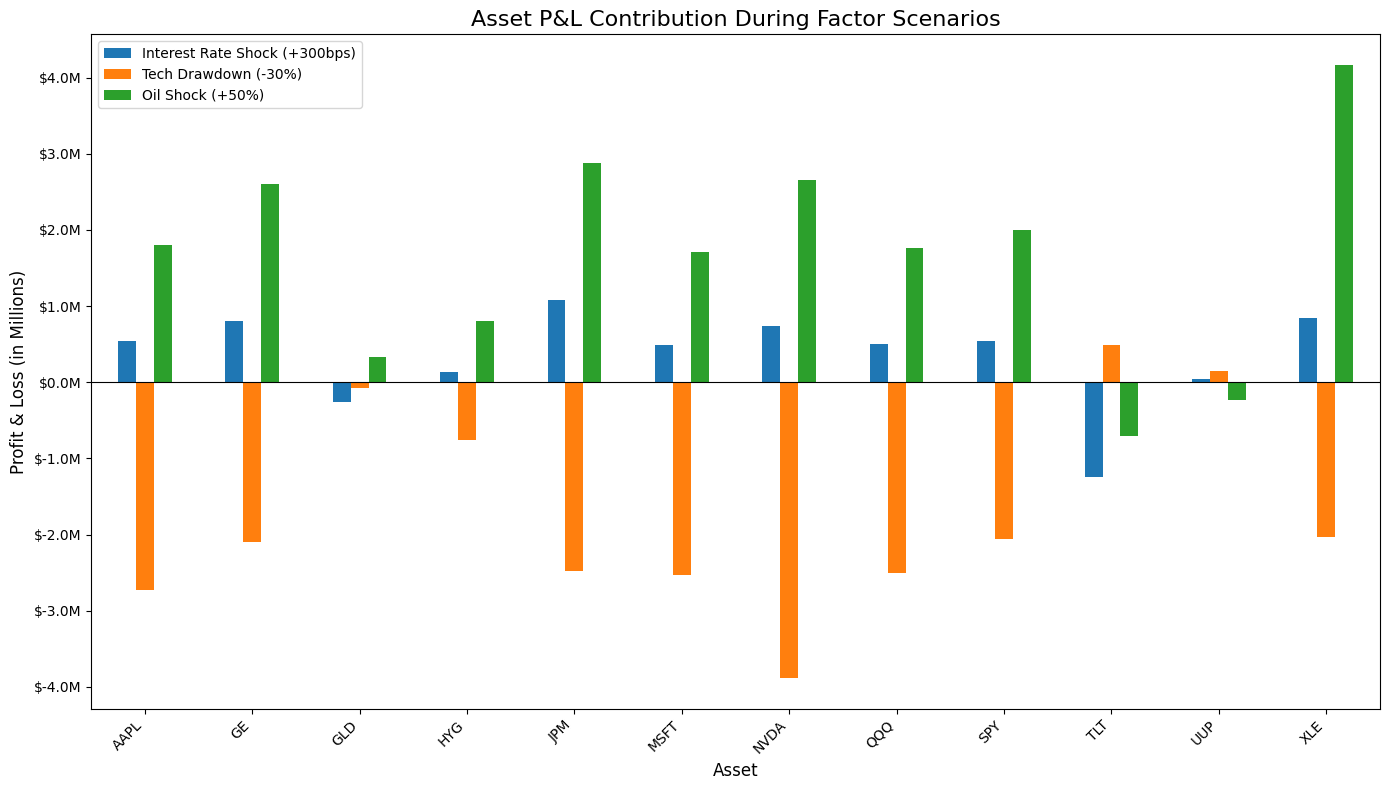

In [17]:
# --- 1. Setup ---
# We assume 'asset_returns', 'weights', and 'portfolio_value' are in memory

# --- 2. Define Factors and Shocks ---
factor_shocks = {
    'Interest Rate Shock (+300bps)': ('TLT', -0.15),
    'Tech Drawdown (-30%)': ('QQQ', -0.30),
    'Oil Shock (+50%)': ('XLE', 0.50)
}

# --- 3. Calculate Betas and Run Scenarios ---
factor_test_results = {}
asset_pnl_by_scenario = pd.DataFrame(index=asset_returns.columns)

print("\nRunning factor-based stress tests...")
for name, (factor_ticker, shock) in factor_shocks.items():
    factor_returns = asset_returns[factor_ticker]
    
    betas = {}
    for asset_name in asset_returns.columns:
        X = factor_returns.values.reshape(-1, 1)
        y = asset_returns[asset_name].values.reshape(-1, 1)
        model = LinearRegression().fit(X, y)
        betas[asset_name] = model.coef_[0][0]
    
    asset_shocks = {asset: beta * shock for asset, beta in betas.items()}
    
    # --- ENHANCEMENT: Store individual asset P&L for this scenario ---
    asset_pnl_by_scenario[name] = [asset_shocks[asset] * w * portfolio_value for asset, w in zip(asset_returns.columns, weights)]
    
    portfolio_shock = sum(asset_shocks[asset] * w for asset, w in zip(asset_returns.columns, weights))
    
    factor_test_results[name] = {
        'Portfolio P&L': f"${portfolio_value * portfolio_shock:,.0f}",
        'Portfolio Return': f"{portfolio_shock*100:.2f}%"
    }

factor_summary = pd.DataFrame(factor_test_results).T

print("\n--- Factor-Based Stress Test Results ---")
print(factor_summary)

# --- 4. Visualize Asset Contributions ---
fig, ax = plt.subplots(figsize=(14, 8))
asset_pnl_by_scenario.plot(kind='bar', ax=ax)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
ax.set_title('Asset P&L Contribution During Factor Scenarios', fontsize=16)
ax.set_ylabel('Profit & Loss (in Millions)', fontsize=12)
ax.set_xlabel('Asset', fontsize=12)
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Findings
| Scenario                        | Portfolio P&L | Portfolio Return |
|---------------------------------|---------------|------------------|
| **Interest Rate Shock (+300bps)** | **+$4.2M**   | **+4.21%**       |
| **Tech Drawdown (–30%)**          | **–$20.5M**  | **–20.50%**      |
| **Oil Shock (+50%)**              | **+$19.8M**  | **+19.79%**      |

### Interpretation
- **Tech Concentration Risk:** The portfolio’s largest vulnerability is to technology equities. A –30% QQQ shock produces a **–20.5% loss**, with AAPL, MSFT, NVDA, and QQQ itself driving the majority of downside.  
- **Rates as Partial Offset:** The portfolio benefits from rising rates (+4.2%). JPM gains over **$1M**, offsetting part of TLT’s large loss, consistent with historical sensitivities.  
- **Energy Tailwind:** A +50% oil shock results in a **+19.8% gain**, primarily from XLE, with additional contributions from GE and JPM.  

### Risk Management Implications
- ✅ **Granular Risk View:** Provides an asset-level decomposition of factor sensitivities, moving beyond aggregate P&L.  
- ✅ **Primary Risk Factor Confirmed:** Tech equity concentration is the clear driver of downside risk.  
- ➡️ **Actionable Hedging:** A targeted hedge (e.g., QQQ puts, or a short basket of tech names) is more efficient than broad-market hedges, allowing preservation of diversification benefits from rates and energy.  

---

## Reverse Stress Test

To identify the portfolio’s **systemic breaking point** by estimating the size of an S&P 500 drawdown required to trigger a catastrophic **–20% portfolio loss**.

### Methodology
- **Portfolio Beta Estimation:** Overall portfolio beta to SPY was computed as the weighted average of the individual asset betas.  
- **Shock Calculation:** Required SPY shock = Target portfolio loss (–20%) ÷ Portfolio beta.  
- **Attribution:** Total loss was decomposed into asset-level contributions based on each position’s beta and weight.  

✅ Setup complete. Target loss: -20%, Shock factor: SPY

Portfolio Beta to SPY: 0.79

--- Reverse Stress Test Result ---
To cause a -20% loss in the portfolio...
The SPY would need to fall by: -25.47%


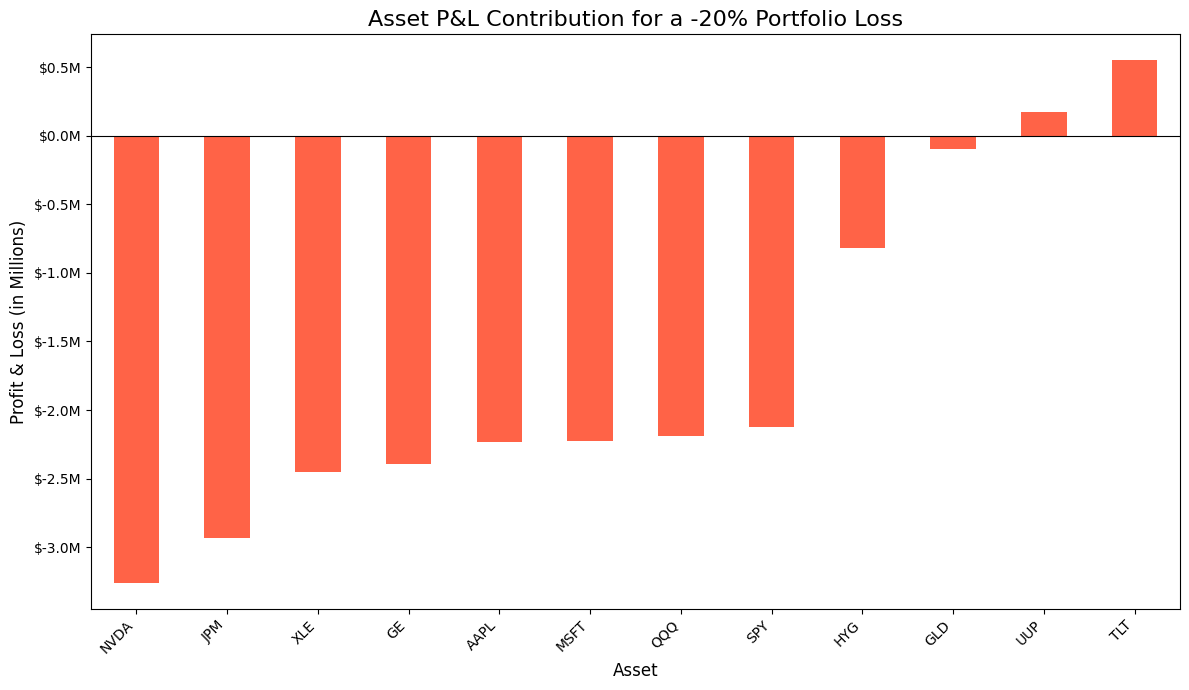

In [18]:
# --- 1. Setup ---
# We assume 'asset_returns' and 'weights' are in memory

# --- 2. Define Reverse Stress Test Parameters ---
target_loss = -0.20 # The portfolio loss we are solving for (-20%)
factor_ticker = 'SPY' # The factor we are shocking (S&P 500)
portfolio_value = 100_000_000 # Assume portfolio value for P&L chart

print(f"✅ Setup complete. Target loss: {target_loss*100:.0f}%, Shock factor: {factor_ticker}")

# --- 3. Calculate the Portfolio's Beta to the Factor ---
factor_returns = asset_returns[factor_ticker]
betas = {}
for asset_name in asset_returns.columns:
    X = factor_returns.values.reshape(-1, 1)
    y = asset_returns[asset_name].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    betas[asset_name] = model.coef_[0][0]

portfolio_beta = sum(betas[asset] * w for asset, w in zip(asset_returns.columns, weights))
print(f"\nPortfolio Beta to {factor_ticker}: {portfolio_beta:.2f}")

# --- 4. Calculate the Required Shock ---
required_shock = target_loss / portfolio_beta
print("\n--- Reverse Stress Test Result ---")
print(f"To cause a {target_loss*100:.0f}% loss in the portfolio...")
print(f"The {factor_ticker} would need to fall by: {required_shock*100:.2f}%")

# --- 5. Visualize the Asset Contributions ---
# Calculate the P&L of each asset in this scenario
asset_shocks = {asset: beta * required_shock for asset, beta in betas.items()}
asset_pnl = {
    asset: shock * w * portfolio_value
    for (asset, shock), w in zip(asset_shocks.items(), weights)
}
asset_pnl_series = pd.Series(asset_pnl)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12, 7))
asset_pnl_series.sort_values().plot(kind='bar', ax=ax, color='tomato')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
ax.set_title(f'Asset P&L Contribution for a {target_loss*100:.0f}% Portfolio Loss', fontsize=16)
ax.set_ylabel('Profit & Loss (in Millions)', fontsize=12)
ax.set_xlabel('Asset', fontsize=12)
ax.axhline(0, color='black', linewidth=0.8)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Findings
| Metric                  | Result    |
|--------------------------|-----------|
| **Portfolio Beta to SPY** | **0.79** |
| **Required SPY Drawdown** | **–25.47%** |

### Interpretation
- **Breaking Point:** A **–25.5% SPY crash** is sufficient to cause a –20% portfolio drawdown. This serves as a clear benchmark for systemic equity risk.  
- **Resilience via Diversification:** A beta < 1 (0.79) reflects risk dampening from non-equity allocations (TLT, GLD, UUP).  
- **Concentrated Vulnerability:** Losses are concentrated in high-beta assets (NVDA, JPM, SPY), while defensive exposures (TLT, UUP) provide positive offsets.  

### Risk Management Implications
- **Clear Risk Benchmark:** Defines a tangible “breaking point” for portfolio resilience.  
- **Systemic Risk Confirmed:** Portfolio vulnerability is dominated by broad U.S. equity drawdowns.  
- **Actionable Hedge List:** Hedge concentration risk in NVDA, JPM, and SPY to reduce effective beta while preserving diversification benefits.  


---

## Final Stress Test Viz and Summary

To consolidate all **historical, factor-based, and reverse stress tests** into a single visualization, providing a holistic view of the portfolio’s crisis vulnerability and resilience.

### Methodology
- **Data Consolidation:** Combined portfolio impacts (% terms) from all six scenarios.  
- **Radar Chart:** Plotted each scenario as an axis, creating a “risk footprint” of vulnerabilities and hedging benefits.  


--- Final Stress Test Summary ---
                               Impact (%)
2008 GFC (Lehman Collapse)         -22.43
2020 COVID-19 Crash                -25.13
Interest Rate Shock (+300bps)        4.21
Tech Drawdown (-30%)               -20.50
Oil Shock (+50%)                    19.79
Shock to SPY for -20% Loss         -25.47


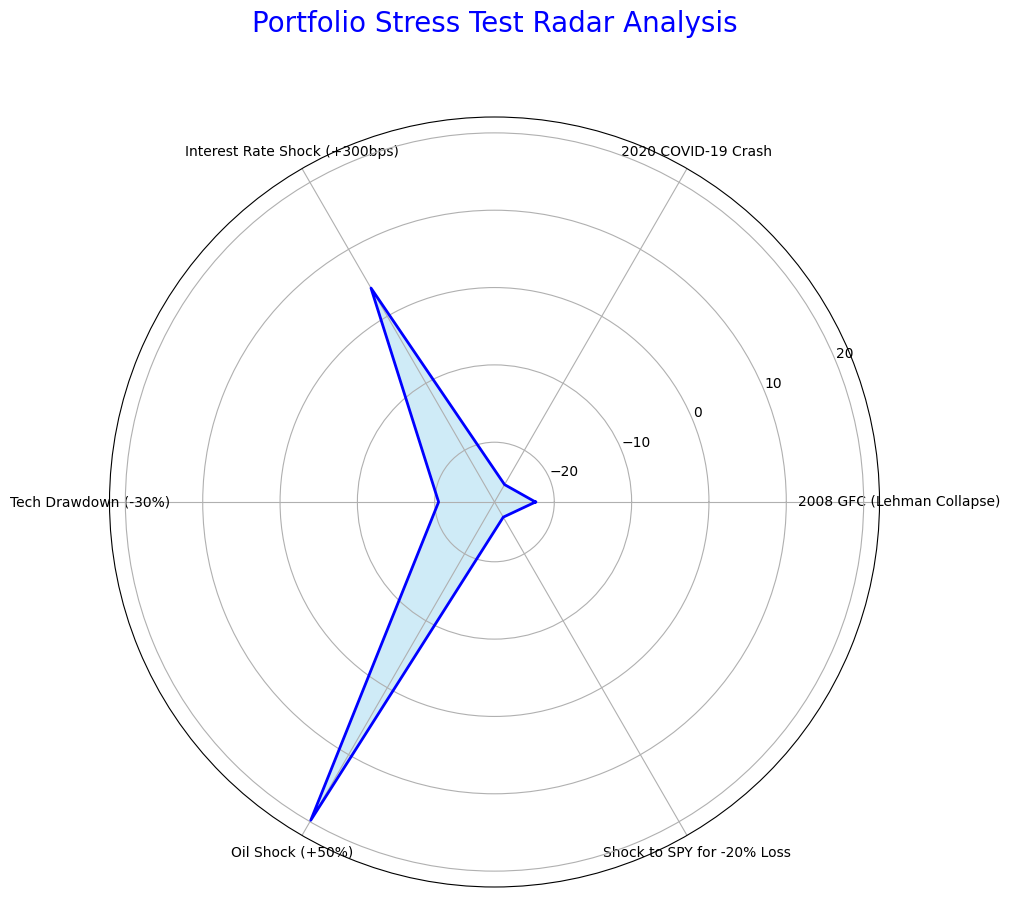

In [20]:
# --- 1. Consolidate All Stress Test Results ---
# We assume the summary DataFrames and variables from your previous cells are in memory
# (stress_summary, factor_summary, required_shock, etc.)

# Extract the portfolio return shock from the historical summary
historical_shocks = stress_summary['Portfolio Return'].str.strip('%').astype(float) / 100
historical_shocks.index = stress_summary.index

# Extract the portfolio return shock from the factor summary
factor_shocks_df = factor_summary['Portfolio Return'].str.strip('%').astype(float) / 100
factor_shocks_df.index = factor_summary.index

# Create the result for the reverse stress test
reverse_test_series = pd.Series(
    {f'Shock to {factor_ticker} for {target_loss*100:.0f}% Loss': required_shock * 100}
)

# Combine all results
summary_series_returns = pd.concat([historical_shocks, factor_shocks_df]) * 100
final_summary = pd.concat([summary_series_returns, reverse_test_series])
final_summary.name = 'Impact (%)'

print("\n--- Final Stress Test Summary ---")
print(final_summary.round(2).to_frame())


# --- 2. Visualize with a Matplotlib Radar Chart ---
labels = final_summary.index
stats = final_summary.values

# Create angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats, [stats[0]]))
angles += angles[:1]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='skyblue', alpha=0.4)
ax.plot(angles, stats, color='blue', linewidth=2)

# Set the labels for each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

# Set the title
ax.set_title('Portfolio Stress Test Radar Analysis', size=20, color='blue', y=1.1)

plt.show()

### Key Findings
- **Systemic Equity Risk:** Largest vulnerabilities in equity-driven shocks:  
  - 2020 COVID Crash: **–25.1%**  
  - 2008 GFC: **–22.4%**  
  - Tech Drawdown: **–20.5%**  
- **Positive Exposures:**  
  - Oil Shock: **+19.8%**  
  - Rate Hike (+300bps): **+4.2%**  
- **Breaking Point:** Reverse stress test shows a **–25.5% SPY crash** is sufficient to cause a –20% portfolio loss.  

### Risk Management Implications
- **Holistic Risk Map:** Radar chart provides a 360° view of portfolio stress response.  
- **Clear Vulnerabilities:** Concentrated downside risk in systemic equity and tech shocks.  
- **Actionable Hedging:** Results guide targeted hedges (e.g., QQQ puts, trimming high-beta equity).  
- **Phase 5 Complete:** A comprehensive stress testing toolkit is now in place, suitable for professional risk reporting.  

---